# <font color='blue'> i. Introduction </font>

## <font color='green'> Milestones 2 </font>

* ### Name : Mangara Haposan Immanuel Siagian
* ### Batch : FTDS-RMT-019

### <font color='green'> Objective </font>
Predicting logo image from the given dataset.

### <font color='green'> Background </font>
In today's digital era, logos are very important because they represent a particular brand or company and have high commercial value. Therefore, the ability to automatically recognize and predict logos in a dataset can have many practical benefits.

With the ability to predict the logo-image, several applications that can be realized include: Brand Identification, Brand Monitoring, Copyright Protection, Visual Search.

With the ability to predict logos in a dataset, this goal will enable the development of practical solutions for the above applications. Through the application of machine learning and image processing techniques, it is hoped that the developed system can provide accurate predictive results and assist in various business and technological contexts.

### <font color='green'> Dataset Explanation </font>
The dataset used is the dataset obtained from Kaggle regarding Logo Detection.

# <font color='blue'> ii. Import Libraries </font>

In [1]:
# Import Library used
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# <font color='blue'> iii. Data Loading </font>

In [2]:
# Import the data you want to process
main_path = r'C:\Users\MANGARA HAPOSAN\Downloads\ms2\raw'

### If the dataset doesn't have train, test, and validation folder, use this code
train_percentage = 0.7
val_percentage = 0.15

categories = os.listdir(main_path)

for category in categories:
    category_dir = os.path.join(main_path, category)
    files = os.listdir(category_dir)
    num_train = int(train_percentage * len(files))
    num_val = int(val_percentage * len(files))
    
    train_dir = os.path.join(main_path, 'train', category)
    val_dir = os.path.join(main_path, 'validation', category)
    test_dir = os.path.join(main_path, 'test', category)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    for i, file in enumerate(files):
        if i < num_train:
            src_path = os.path.join(category_dir, file)
            dst_path = os.path.join(train_dir, file)
            shutil.move(src_path, dst_path)
        elif i < num_train + num_val:
            src_path = os.path.join(category_dir, file)
            dst_path = os.path.join(val_dir, file)
            shutil.move(src_path, dst_path)
        else:
            src_path = os.path.join(category_dir, file)
            dst_path = os.path.join(test_dir, file)
            shutil.move(src_path, dst_path)

print("Done")

In [3]:
# Check for missing values
def check_missing_value(folder_path):
    is_missing = False

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)

            try:
                img = cv2.imread(file_path)
                if img is None:
                    print("File not found or cannot be opened:", file_path)
                    is_missing = True
            except Exception as e:
                print("Error:", e)
                is_missing = True

    return is_missing

folder_path = r'C:\Users\MANGARA HAPOSAN\Downloads\ms2\raw'
is_missing = check_missing_value(folder_path)
if is_missing:
    print("There is a missing value in the file.")
else:
    print("There are no missing values in the file.")

There are no missing values in the file.


In [4]:
# Use the train, val, and test folder as the train, val, and test data
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'validation')
test_dir = os.path.join(main_path, 'test')

# <font color='blue'> iv. Exploratory Data Analysis (EDA) </font>

In [5]:
# Check the number of files in each folder
def check_dir(dir=None, labels=None):
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'total {label} : {num_data}')

print('train set: \n' + '='*50) 
check_dir(train_dir,['']) 

print('val set: \n' + '='*50) 
check_dir(val_dir,[''])

print('\ntest set: \n' + '='*50) 
check_dir(test_dir,['']) 

train set: 
total  : 63
val set: 
total  : 63

test set: 
total  : 63


In [6]:
# Check the total image file
def count_image_files(folder_path):
    total_images = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                total_images += 1

    return total_images

folder_path = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\logo"
total_images = count_image_files(folder_path)
print("Total image files: ", total_images)

Total image files:  550


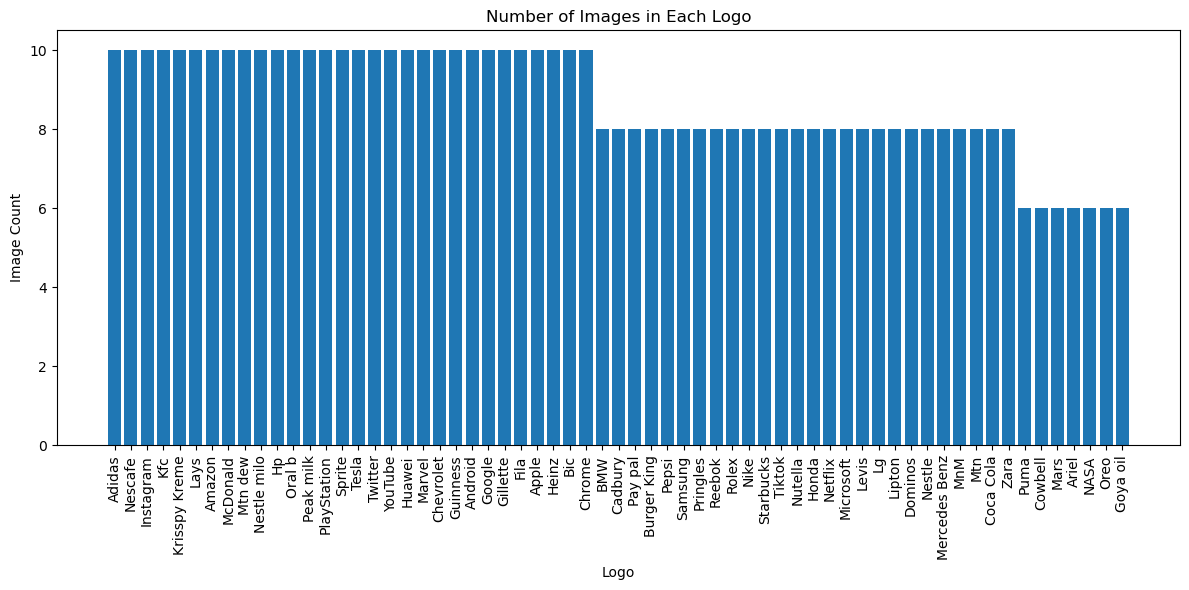

In [7]:
# Check the total image file in each logo
data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\logo"  
logo_folders = os.listdir(data_dir)
logo_counts = []

for folder in logo_folders:
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        logo_counts.append((folder, num_images))

df_logo_counts = pd.DataFrame(logo_counts, columns=['Logo', 'Image Count'])
df_logo_counts.sort_values(by='Image Count', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.bar(df_logo_counts['Logo'], df_logo_counts['Image Count'])
plt.xlabel('Logo')
plt.ylabel('Image Count')
plt.xticks(rotation=90)
plt.title('Number of Images in Each Logo')
plt.tight_layout()
plt.show()

From the graph it can be concluded that the highest total images in 1 folder are 10 and the lowest total images in 1 folder are 6.

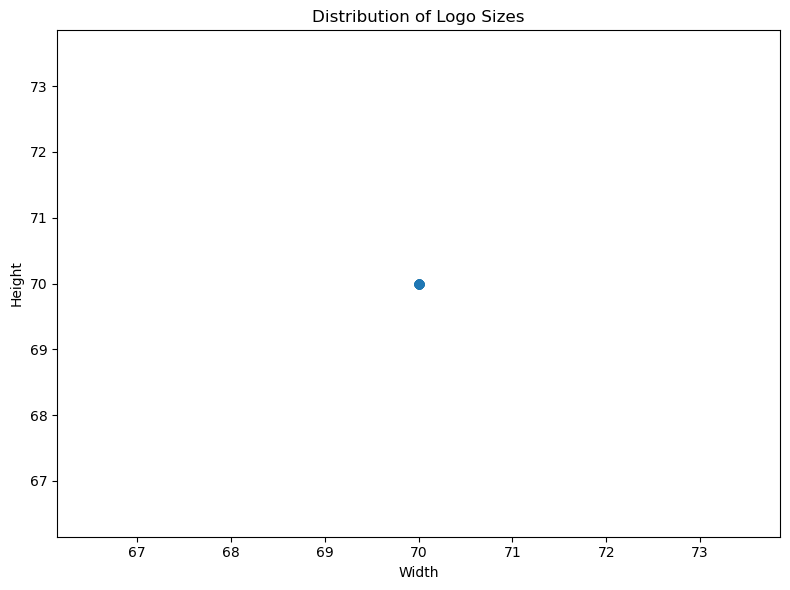

In [8]:
# Check the size of the image used
data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\logo"  
logo_sizes = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        image_file = os.listdir(folder_path)[0]
        image_path = os.path.join(folder_path, image_file)
        
        image = cv2.imread(image_path)
        
        logo_sizes.append(image.shape[:2])

logo_sizes = np.array(logo_sizes)

plt.figure(figsize=(8, 6))
plt.scatter(logo_sizes[:, 1], logo_sizes[:, 0])
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribution of Logo Sizes')
plt.tight_layout()
plt.show()

From the graph it can be concluded that the logo size distribution is only 70 x 70.

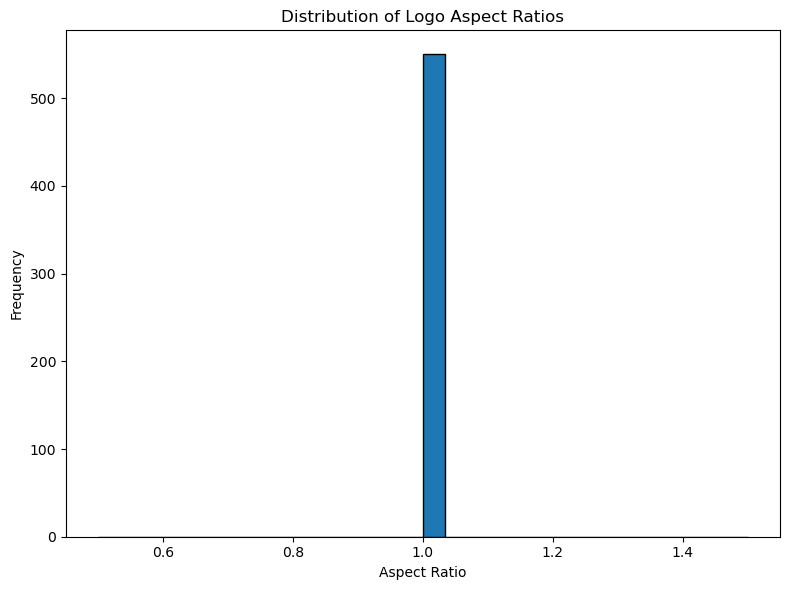

In [9]:
# Check the ratio of the images used
data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\logo"  
logo_aspect_ratios = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)

            image = cv2.imread(image_path)

            height, width, _ = image.shape
            aspect_ratio = width / height

            logo_aspect_ratios.append(aspect_ratio)

logo_aspect_ratios = np.array(logo_aspect_ratios)

plt.figure(figsize=(8, 6))
plt.hist(logo_aspect_ratios, bins=30, edgecolor='black')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Logo Aspect Ratios')
plt.tight_layout()
plt.show()

From the graph it can be concluded that the logo ratio distribution is only 1.

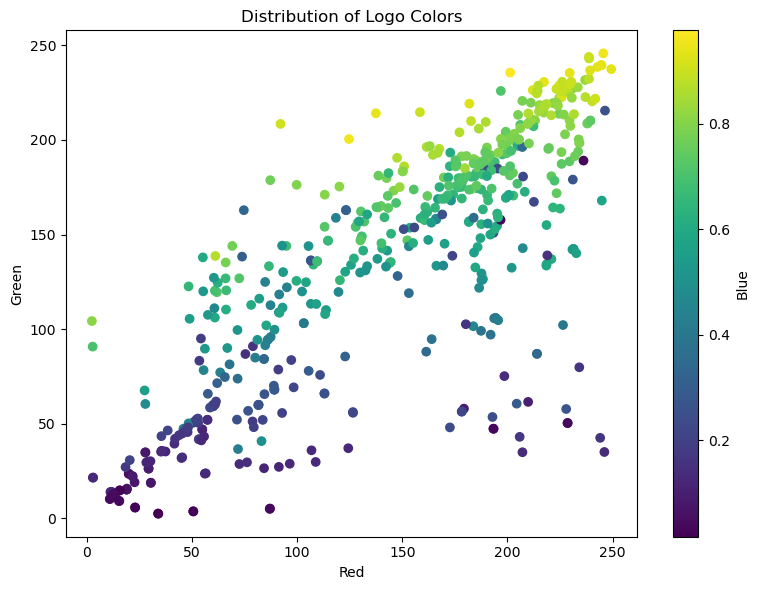

In [10]:
# Check the color distribution used
data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\logo"  
logo_colors = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            color_mean = np.mean(image_rgb, axis=(0, 1))
            logo_colors.append(color_mean)

logo_colors = np.array(logo_colors)

plt.figure(figsize=(8, 6))
plt.scatter(logo_colors[:, 0], logo_colors[:, 1], c=logo_colors[:, 2] / 255.0, cmap='viridis')
plt.xlabel('Red')
plt.ylabel('Green')
plt.title('Distribution of Logo Colors')
plt.colorbar(label='Blue')
plt.tight_layout()
plt.show()

From the graph it can be concluded that the color distribution is balanced.

# <font color='blue'> v. Feature Engineering </font>

### <font color='green'> AUGMENTATION </font>

In [11]:
# Set the input value
img_height = 70
img_width = 70
inputs = (img_height, img_width, 3)

# Set data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

# Load train, validation, and test datasets
train_data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\raw\train"
validation_data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\raw\validation"
test_data_dir = r"C:\Users\MANGARA HAPOSAN\Downloads\ms2\raw\test"
batch_size = 32

In [12]:
# Using data augmentation on train datasets
train_datagen = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=data_augmentation)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

# Using data augmentation on validation datasets
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

# Using data augmentation on test datasets
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 368 images belonging to 63 classes.
Found 56 images belonging to 63 classes.
Found 126 images belonging to 63 classes.


In the given code, there are several preprocessing techniques used, namely:

Data Augmentation:

* RandomFlip: Apply horizontal random rotation to the image.
* RandomRotation: Applies a random rotation to the image by 0.1 radians.
* RandomZoom: Applies a random zoom to the image by 0.1.
* Rescaling: Use rescaling in the data generator to divide the pixel value by 255, so that the pixel value is in the range between 0 and 1.

This augmentation is used for the following reasons:

* RandomFlip, RandomRotation, and RandomZoom are used to increase the data variation to prevent overfitting and to add image data because the image data used is small.
* Used Rescaling to handling outlier and improve image data quality.

# <font color='blue'> vi. Model Definition </font>

### <font color='green'> a. ANN TRAINING </font>

In [13]:
# Clear Session
tf.keras.backend.clear_session()

In [14]:
# Build the CNN model
modelt = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(63, activation="softmax")  
])

# Compilation and training of models
modelt.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])
modelt.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

The architecture designed in the code is as follows:

Input Layers:

* Type: Conv2D
* Number of filters: 16
* Filter size: (3, 3)
* Activation function: ReLU
* Input shapes: (img_height, img_width, 3)

Hidden Layers:

* Type: MaxPooling2D
* Pool size: (2, 2)

Hidden Layers:

* Type: Conv2D
* Number of filters: 32
* Filter size: (3, 3)
* Activation function: ReLU

Hidden Layers:

* Type: MaxPooling2D
* Pool size: (2, 2)

Hidden Layers:

* Type: Conv2D
* Number of filters: 64
* Filter size: (3, 3)
* Activation function: ReLU

Hidden Layers:

* Type: MaxPooling2D
* Pool size: (2, 2)

Hidden Layers:

* Type: Flattens

Hidden Layers:

* Type: Dense
* Number of neurons: 64
* Activation function: ReLU

Output Layers:

* Type: Dense
* Number of neurons: 63
* Activation function: Softmax

In this architecture, there are 9 layers.

### <font color='green'> b. ANN IMPROVEMENT </font>

In [15]:
# Clear Session
tf.keras.backend.clear_session()

## Things to do to improve performance:
* Lowering the learning rate.

In [16]:
# Build the CNN model
modeli = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(63, activation="softmax")
])

# Compilation and training of models
modeli.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
modeli.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

The architecture designed in the code is as follows:

Input Layers:

* Type: Conv2D
* Number of filters: 16
* Filter size: (3, 3)
* Activation function: ReLU
* Input shapes: (img_height, img_width, 3)

Hidden Layers:

* Type: MaxPooling2D
* Pool size: (2, 2)

Hidden Layers:

* Type: Conv2D
* Number of filters: 32
* Filter size: (3, 3)
* Activation function: ReLU

Hidden Layers:

* Type: MaxPooling2D
* Pool size: (2, 2)

Hidden Layers:

* Type: Conv2D
* Number of filters: 64
* Filter size: (3, 3)
* Activation function: ReLU

Hidden Layers:

* Type: MaxPooling2D
* Pool size: (2, 2)

Hidden Layers:

* Type: Flattens

Hidden Layers:

* Type: Dense
* Number of neurons: 64
* Activation function: ReLU

Output Layers:

* Type: Dense
* Number of neurons: 63
* Activation function: Softmax

In this architecture, there are 9 layers.

# <font color='blue'> vii. Model Training </font>

### <font color='green'> a. ANN TRAINING </font>

In [17]:
# Train the Model
start_time = time.time()
history_t = modelt.fit(train_generator, epochs=50, validation_data=validation_generator)
end_time = time.time()
execution_time = end_time - start_time
print("Total execution time:", execution_time, "seconds")

Epoch 1/50
12/12 [==============================] - 6s 423ms/step - loss: 4.2322 - accuracy: 0.0163 - val_loss: 4.1393 - val_accuracy: 0.0357
Epoch 2/50
12/12 [==============================] - 5s 412ms/step - loss: 4.1418 - accuracy: 0.0190 - val_loss: 4.1372 - val_accuracy: 0.0179
Epoch 3/50
12/12 [==============================] - 5s 414ms/step - loss: 4.1385 - accuracy: 0.0136 - val_loss: 4.1342 - val_accuracy: 0.0179
Epoch 4/50
12/12 [==============================] - 5s 401ms/step - loss: 4.1361 - accuracy: 0.0163 - val_loss: 4.1315 - val_accuracy: 0.0179
Epoch 5/50
12/12 [==============================] - 5s 424ms/step - loss: 4.1345 - accuracy: 0.0190 - val_loss: 4.1297 - val_accuracy: 0.0179
Epoch 6/50
12/12 [==============================] - 5s 408ms/step - loss: 4.1332 - accuracy: 0.0190 - val_loss: 4.1279 - val_accuracy: 0.0179
Epoch 7/50
12/12 [==============================] - 5s 426ms/step - loss: 4.1321 - accuracy: 0.0190 - val_loss: 4.1254 - val_accuracy: 0.0179
Epoch 

### <font color='green'> b. ANN IMPROVEMENT </font>

In [18]:
# Train the Model
start_time = time.time()
history_i = modeli.fit(train_generator, epochs=50, validation_data=validation_generator)
end_time = time.time()
execution_time = end_time - start_time
print("Total execution time:", execution_time, "seconds")

Epoch 1/50
12/12 [==============================] - 6s 452ms/step - loss: 4.1536 - accuracy: 0.0163 - val_loss: 4.1060 - val_accuracy: 0.0536
Epoch 2/50
12/12 [==============================] - 5s 447ms/step - loss: 4.0874 - accuracy: 0.0543 - val_loss: 4.0044 - val_accuracy: 0.0536
Epoch 3/50
12/12 [==============================] - 5s 450ms/step - loss: 3.9671 - accuracy: 0.0516 - val_loss: 3.8181 - val_accuracy: 0.0714
Epoch 4/50
12/12 [==============================] - 5s 425ms/step - loss: 3.7394 - accuracy: 0.0761 - val_loss: 3.4667 - val_accuracy: 0.1607
Epoch 5/50
12/12 [==============================] - 5s 433ms/step - loss: 3.4315 - accuracy: 0.1549 - val_loss: 3.0581 - val_accuracy: 0.1607
Epoch 6/50
12/12 [==============================] - 6s 456ms/step - loss: 3.0753 - accuracy: 0.2364 - val_loss: 2.8643 - val_accuracy: 0.1607
Epoch 7/50
12/12 [==============================] - 5s 430ms/step - loss: 2.7599 - accuracy: 0.2609 - val_loss: 2.5189 - val_accuracy: 0.3571
Epoch 

# <font color='blue'> viii. Model Evaluation </font>

### <font color='green'> a. ANN TRAINING </font>

In [19]:
# Create DataFrame
history_t_df = pd.DataFrame(history_t.history)
history_t_df

,loss,accuracy,val_loss,val_accuracy
0,4.232233,0.016304,4.139302,0.035714
1,4.141808,0.019022,4.137179,0.017857
2,4.138452,0.013587,4.134156,0.017857
3,4.136119,0.016304,4.131454,0.017857
4,4.134503,0.019022,4.129653,0.017857
5,4.133156,0.019022,4.127860,0.017857
6,4.132072,0.019022,4.125421,0.017857
7,4.130908,0.010870,4.124490,0.017857
8,4.130124,0.019022,4.124991,0.017857
9,4.130058,0.008152,4.124053,0.017857


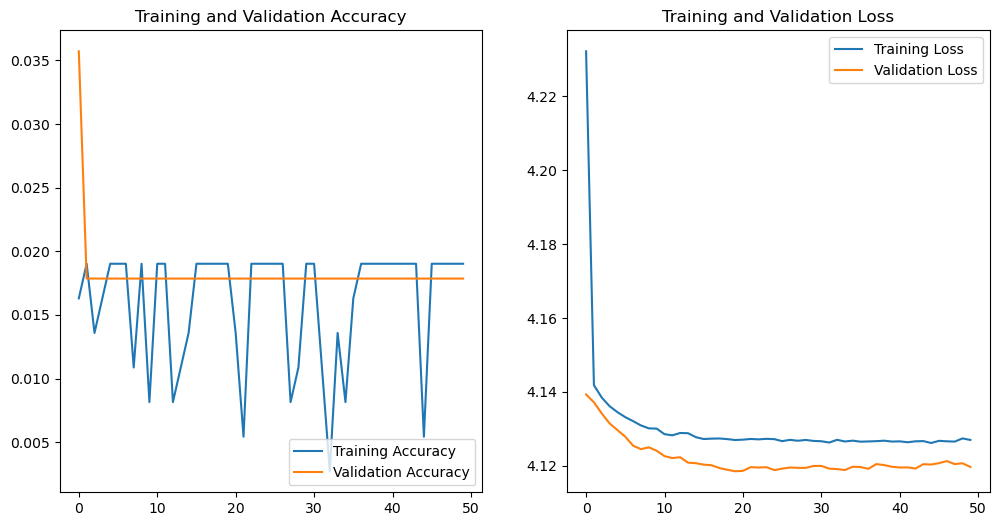

In [20]:
# Plot Training Results
acc = history_t.history['accuracy']
val_acc = history_t.history['val_accuracy']

loss = history_t.history['loss']
val_loss = history_t.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Test Results
test_results_t = modelt.evaluate(test_generator, verbose=0)
print(f'Test Loss     : {test_results_t[0]:.4f}')
print(f'Test Accuracy : {test_results_t[1]:.4f}')

Test Loss     : 4.1609
Test Accuracy : 0.0159


### <font color='green'> b. ANN IMPROVEMENT </font>

In [22]:
# Create DataFrame
history_i_df = pd.DataFrame(history_i.history)
history_i_df

,loss,accuracy,val_loss,val_accuracy
0,4.153563,0.016304,4.105957,0.053571
1,4.087431,0.054348,4.004377,0.053571
2,3.967054,0.051630,3.818106,0.071429
3,3.739428,0.076087,3.466674,0.160714
4,3.431482,0.154891,3.058147,0.160714
5,3.075259,0.236413,2.864291,0.160714
6,2.759866,0.260870,2.518873,0.357143
7,2.447106,0.372283,2.431880,0.303571
8,2.262218,0.380435,2.239445,0.428571
9,1.977584,0.478261,1.945511,0.482143


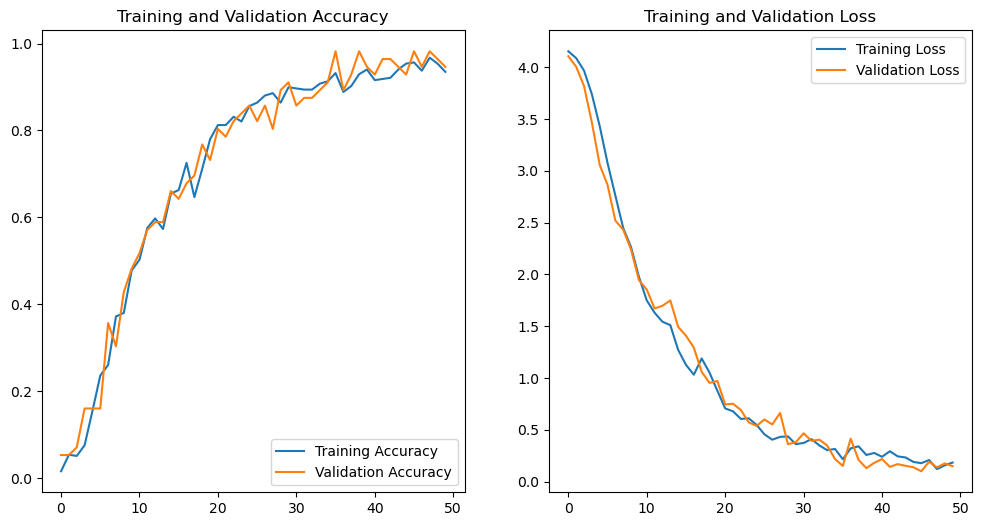

In [23]:
# Plot Improvement Results
acc = history_i.history['accuracy']
val_acc = history_i.history['val_accuracy']

loss = history_i.history['loss']
val_loss = history_i.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Test Results
test_results_i = modeli.evaluate(test_generator, verbose=0)
print(f'Test Loss     : {test_results_i[0]:.4f}')
print(f'Test Accuracy : {test_results_i[1]:.4f}')

Test Loss     : 0.1258
Test Accuracy : 0.9603


CNN (Convolutional Neural Network) performance refers to how well the CNN model can learn and generalize patterns in image data during training and testing.

Performance during Training and Testing:

* Accuracy: The percentage of images that are correctly classified by the CNN model in the data.
* Loss: Measures how well the CNN model fits the data. The goal is to minimize this loss.

Good performance during Training and Testing means that the CNN model is able to learn and capture patterns in the data well. The model must achieve high accuracy and low loss when interacting with the data. However, high performance on data alone does not guarantee good performance on data that has never been seen before.

**Based on these evaluation, the Improvement Model has a better overall performance compared to the Training Model. The Improvement Model has slightly higher accuracy and has slightly lower loss. This shows that the Improvement Model can better classify real and fake logo as a whole.**

The CNN model can incorrectly predict data in a number of situations, including:

* Fuzzy or noisy data: If the rendered image has a high level of blur or significant noise, the CNN model may have difficulty recognizing relevant features and patterns. This can result in wrong predictions.

* Poorly-exposed data: Insufficient exposure or overexposure can change the appearance of objects in the image. CNN models may have difficulty distinguishing important objects or features under extreme lighting conditions.

* Obstructed or incomplete objects: If objects in an image are obscured by other objects or only part of the object is visible, the CNN model may not have enough information to classify the objects correctly. This can result in incorrect or ambiguous predictions.

* Less representative class: If the class you want to predict has a limited number of examples in the training data, the CNN model may not gain sufficient understanding of the features that are unique to that class. As a result, the model may produce incorrect or inaccurate predictions for examples that are representative of that class.

* Objects that have unusual poses: If objects in an image have unusual or unusual poses or angles, the CNN model may have difficulty recognizing the objects correctly. Models can be trained in only a limited variety of poses or viewing angles, and thus cannot correctly classify objects in unusual poses.

It is important to note that the performance of the CNN model can be improved by improving the quality of the training data, adjusting the model architecture, using data augmentation techniques, and optimizing the training parameters.

# <font color='blue'> ix. Model Saving </font>

In [25]:
# Freeze Model
modeli.trainable = False
modeli.summary()

# Save CNN Model
modeli.save('logo_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

# <font color='blue'> xi. Conclusion </font>

### Based on the results of the EDA, information is obtained:
* From the graph it can be concluded that the highest total images in 1 folder are 10 and the lowest total images in 1 folder are 6.
* From the graph it can be concluded that the logo size distribution is only 70 x 70.
* From the graph it can be concluded that the logo ratio distribution is only 1.
* From the graph it can be concluded that the color distribution is balanced.

### Based on Both Model evaluation:
Based on these evaluation, the Improvement Model has a better overall performance compared to the Training Model. The Improvement Model has slightly higher accuracy and has slightly lower loss. This shows that the Improvement Model can better classify real and fake logo as a whole.

### Related to the Business Domain.
For a business context, the Improvement Model is very good because it has a relatively high accuracy and low loss to distinguish between real and fake logo.

### The advantages of the Improvement Model are:
* Can process data more accurately.

### The disadvantages of the Improvement Model are:
* The results given may be misclassified due to the small number of datasets.

To achieve even better results, Model Improvement can be done.

### To do a Model Improvement, things that can be done include:
* Using a more complex algorithm.
* Added more features.
* Perform better data preprocessing.